## **Hyperparameter tuning**

**i) Import libraries**

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
import joblib

**ii) Load models and test train splits for tuning**

In [5]:
# Import the best model - Random Forest
rf_model = joblib.load('/home/davidkibet/Desktop/Life Expectancy ML/models/rf_model.pkl')
lgb_model = joblib.load('/home/davidkibet/Desktop/Life Expectancy ML/models/LGB_model.pkl')
# load training and test sets
X_train = joblib.load("/home/davidkibet/Desktop/Life Expectancy ML/models/train_test_sets/X_train.pkl")
X_test = joblib.load("/home/davidkibet/Desktop/Life Expectancy ML/models/train_test_sets/X_test.pkl")
y_train = joblib.load("/home/davidkibet/Desktop/Life Expectancy ML/models/train_test_sets/y_train.pkl")
y_test = joblib.load("/home/davidkibet/Desktop/Life Expectancy ML/models/train_test_sets/y_test.pkl")
 

In [6]:
cols = ['Adult Mortality', 'infant deaths',
       ' BMI ',
       'under-five deaths ', 'Polio',
       ' HIV/AIDS', 'GDP',
       ' thinness 5-9 years', 'Income composition of resources', 'Schooling']

In [7]:
X_train[cols].shape

(2013, 10)

### **a) RandomForestRegressor**

**i) Initialize the model**

In [8]:
rf = RandomForestRegressor(random_state=42)

**ii) Parameters and RandomizedSearchCV**

In [9]:
param_dist = {
    "n_estimators": [50, 100, 200], # number of trees
    "max_depth": [None, 3, 5, 7], # Tree depth
    "min_samples_split": [10, 20], # Minimum samples to split internal node
    "min_samples_leaf": [10, 15], # Minimum samples in leaf node

    # Regulazition parameters
    "max_features": ["sqrt", "log2"], # Limit feature
    'bootstrap': [True],  # Use bootstrap samples

    # Constraining tree growth
    'max_leaf_nodes': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100] # Limit number of leaf nodes
}
    # Setup cross-validation
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,  # Number of random combinations to try
    cv=kfold,  # kfold
    scoring="neg_mean_squared_error",
    verbose=1,
    n_jobs=-1  # Use all CPU cores
)

In [10]:
random_search.fit(X_train[cols], y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(), n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [None, 3, 5, 7],
                                        'max_features': ['sqrt', 'log2'],
                                        'max_leaf_nodes': [10, 20, 30, 40, 50,
                                                           60, 70, 80, 90,
                                                           100],
                                        'min_samples_leaf': [10, 15],
                                        'min_samples_split': [10, 20],
                                        'n_estimators': [50, 100, 200]},
                   scoring='neg_mean_squared_error', verbose=1)

**iii) Get best parameter**

In [11]:
best_rf = random_search.best_estimator_
print("Best Params:", random_search.best_params_)

Best Params: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_leaf_nodes': 80, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}


**iv) Predict**

In [12]:
y_pred_test = best_rf.predict(X_test[cols])
y_pred_train = best_rf.predict(X_train[cols])

**v) Evaluate**

In [13]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

- **Train Metrics  and Test metrics**

In [14]:
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print(f"Train MSE: {mse_train:.4f}")
print(f"Train MAE: {mae_train:.4f}")
print(f"Train R² Score: {r2_train:.4f}")

mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"Test MSE: {mse_test:.4f}")
print(f"Test MAE: {mae_test:.4f}")
print(f"Test R² Score: {r2_test:.4f}")

Train MSE: 3.8382
Train MAE: 1.3162
Train R² Score: 0.9602
Test MSE: 5.8313
Test MAE: 1.7219
Test R² Score: 0.9187


In [15]:
# Define metrics
metrics = ["MSE", "MAE", "R² Score"]
train_scores = [4.0652, 1.3730, 0.9578]
test_scores = [5.9819, 1.7401, 0.9166]


In [16]:
import numpy as np
import matplotlib.pyplot as plt

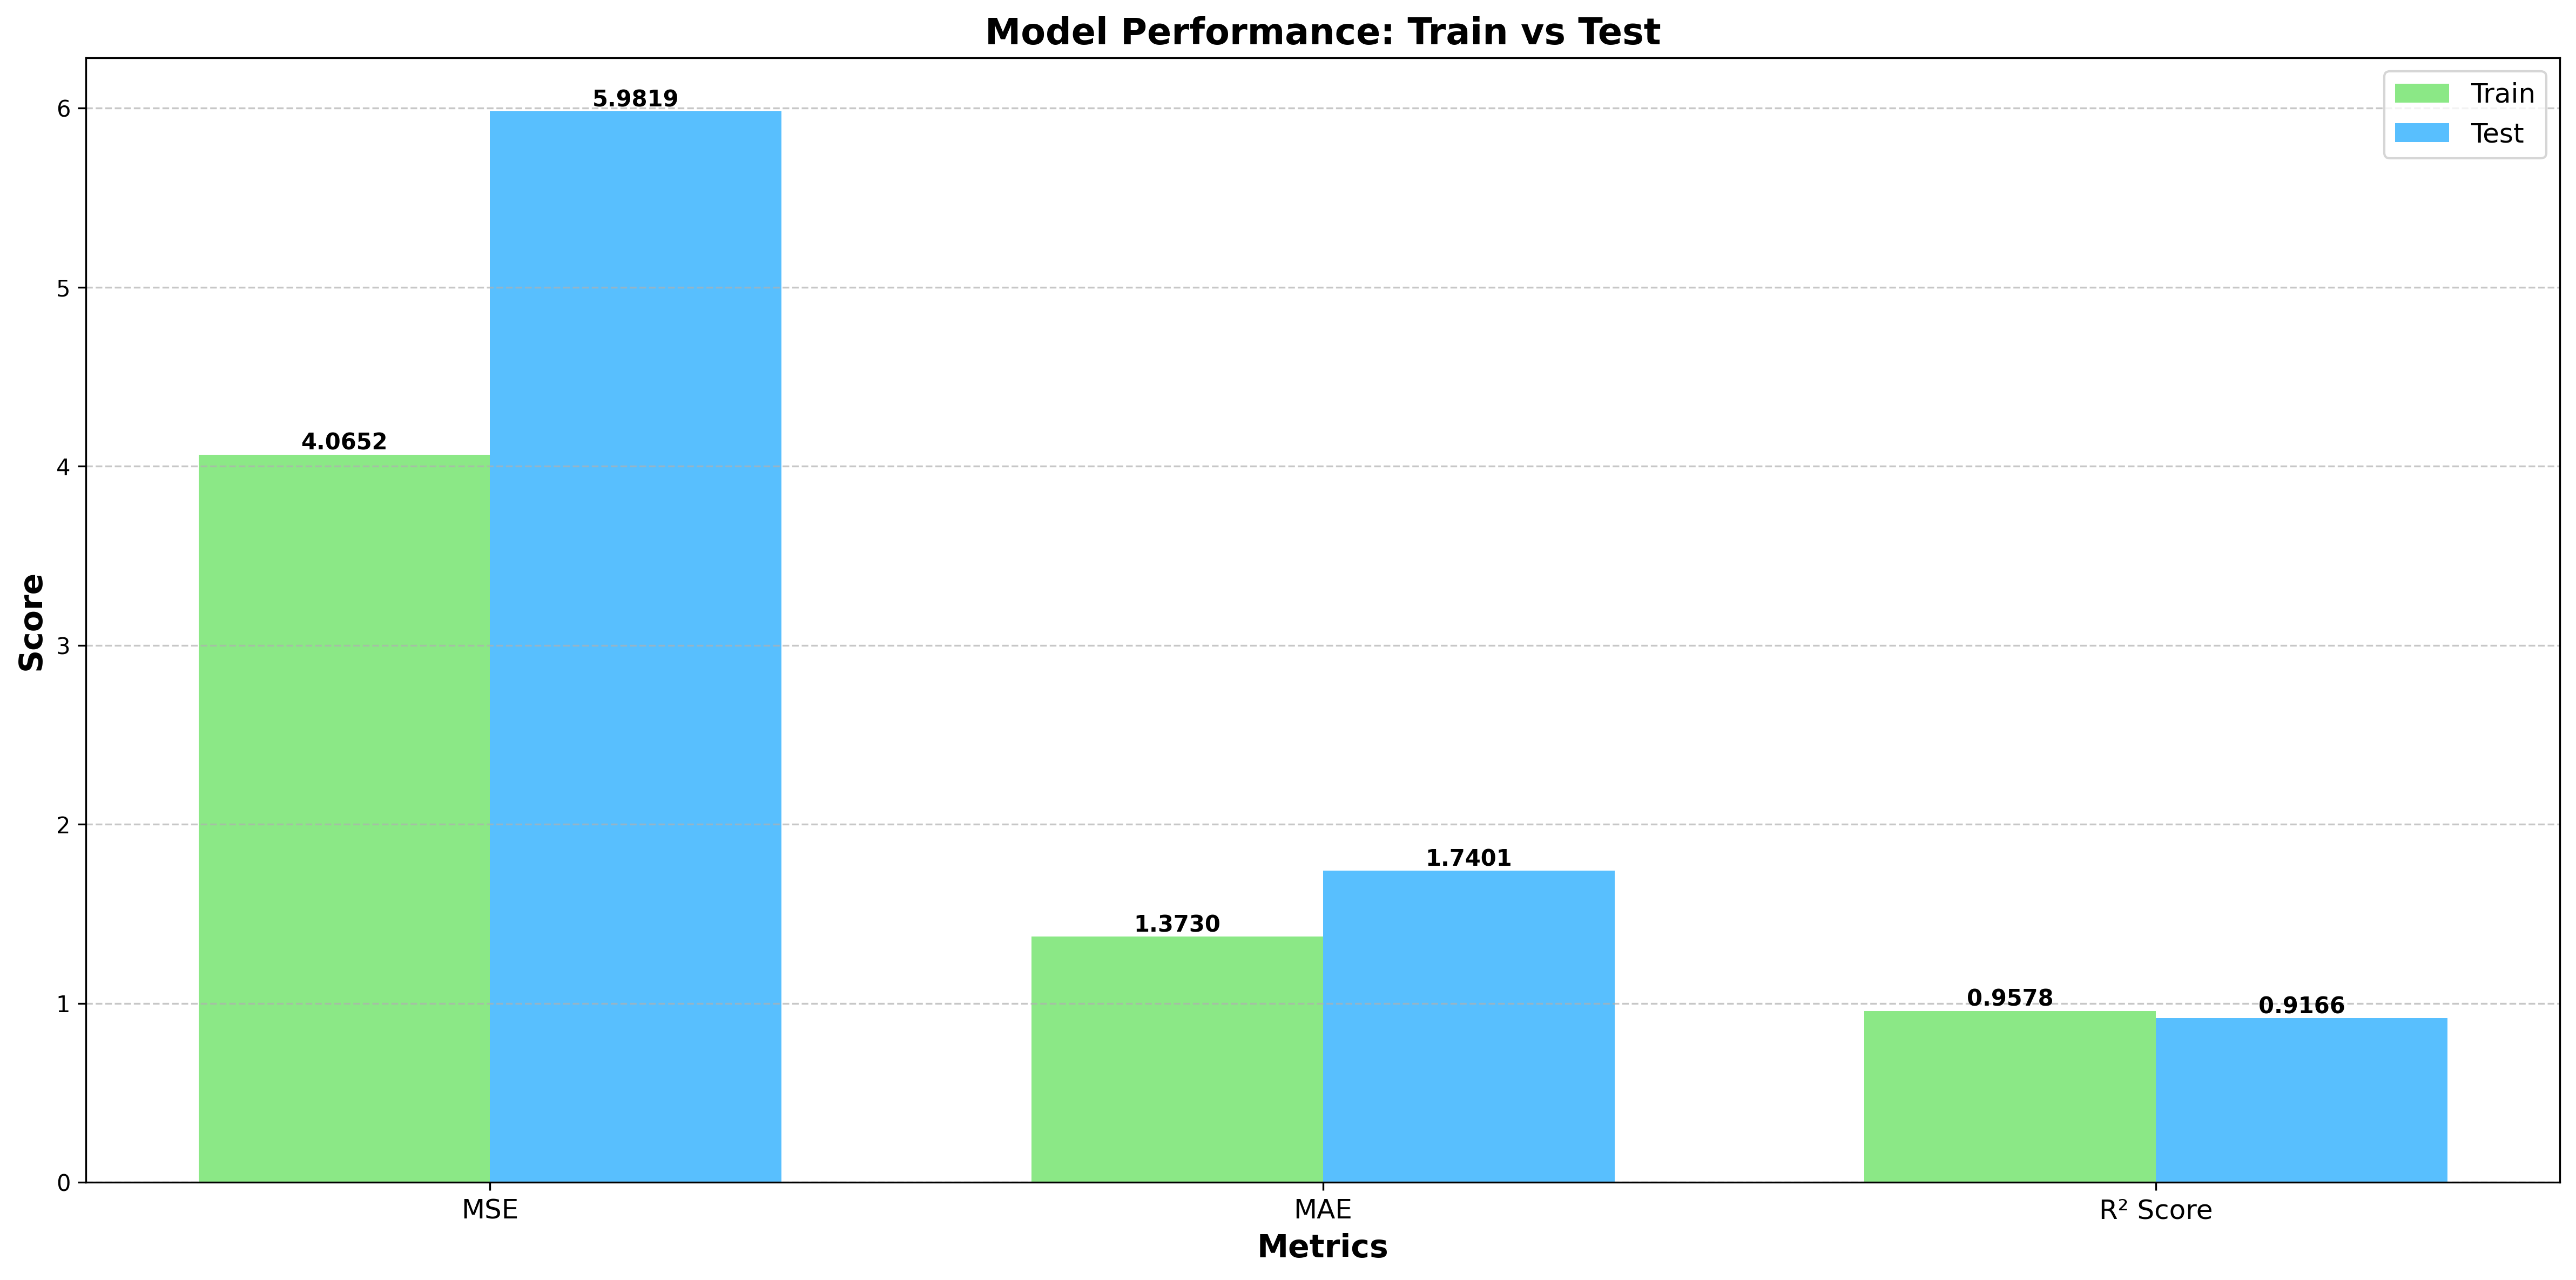

In [17]:
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(16, 8), dpi=300)

# Train scores bars
train_bars = ax.bar(x - width/2, train_scores, width, label='Train', 
                    color='#7ee679', alpha=0.9)

# Test scores bars
test_bars = ax.bar(x + width/2, test_scores, width, label='Test', 
                    color='#46b8fe', alpha=0.9)

# Customize the plot
ax.set_xlabel('Metrics', fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontsize=14, fontweight='bold')
ax.set_title('Model Performance: Train vs Test', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)

# Add value labels on the bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

add_value_labels(train_bars)
add_value_labels(test_bars)

# Add a subtle grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and add legend
ax.legend(fontsize=12)
plt.tight_layout()

**vi) Extract feature importance**

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances
importances = best_rf.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame(
    {"Feature": X_train[cols].columns, "Importance": importances}
).sort_values(by="Importance", ascending=False)

# Display the top features
print(feature_importance_df)

                           Feature  Importance
8  Income composition of resources    0.265535
5                         HIV/AIDS    0.230560
0                  Adult Mortality    0.176374
9                        Schooling    0.156208
2                             BMI     0.058451
3               under-five deaths     0.030552
6                              GDP    0.027780
7               thinness 5-9 years    0.022700
4                            Polio    0.018848
1                    infant deaths    0.012991


**vii) Plot - Feature Importance**

In [19]:
import seaborn as sns
import numpy as np

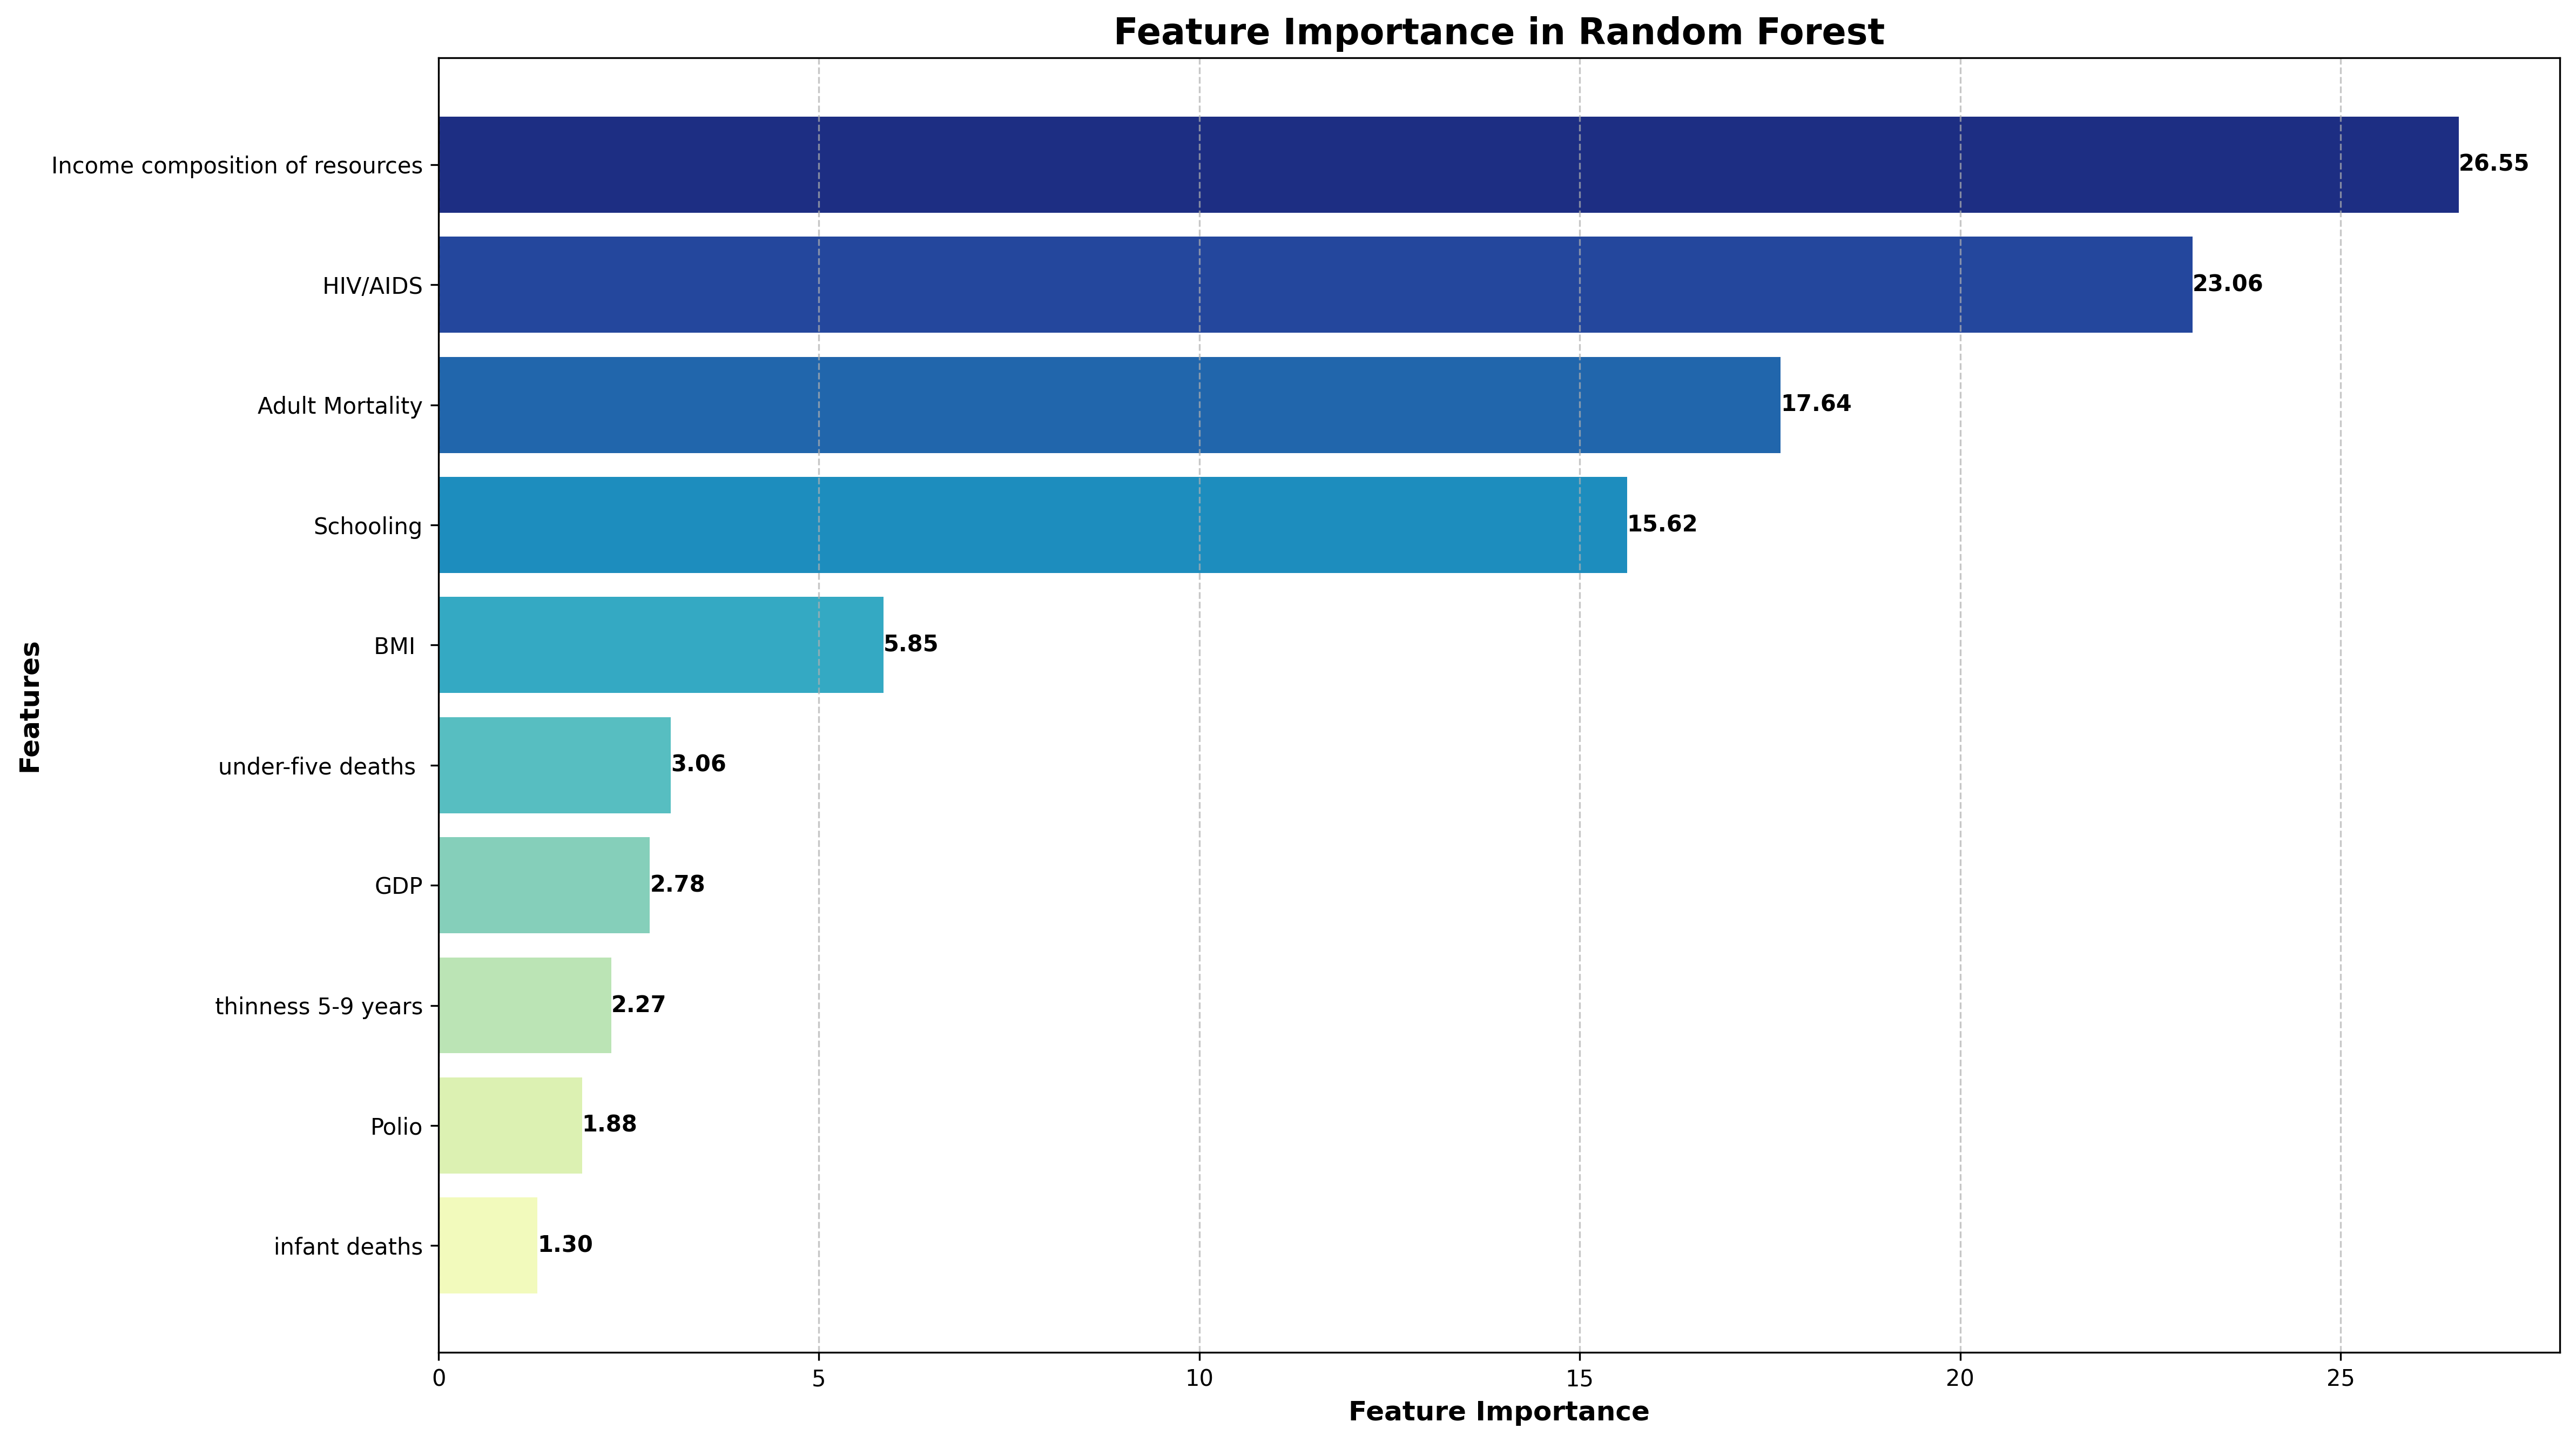

In [20]:
# Convert importance to percentages
feature_importance_df["Importance"] *= 100   

plt.figure(figsize=(16, 9), dpi=300)

# Create horizontal bar plot with gradient coloring
bars = plt.barh(feature_importance_df["Feature"], 
                feature_importance_df["Importance"], 
                color=sns.color_palette("YlGnBu", len(feature_importance_df))[::-1])

# Customize the plot
plt.xlabel("Feature Importance", fontsize=12, fontweight='bold')
plt.ylabel("Features", fontsize=12, fontweight='bold')
plt.title('Feature Importance in Random Forest', fontsize=16, fontweight='bold')

# Invert y-axis to show most important features at the top
plt.gca().invert_yaxis()

# Add value labels to the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}', 
                ha='left', va='center', fontweight='bold', fontsize=10)

# Adjust layout and add grid
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

In [21]:
import plotly.express as px
import seaborn as sns
import matplotlib.colors as mcolors

# Convert importance to percentages
# feature_importance_df["Importance"] *= 100  

# Generate and convert Seaborn color palette to hex
colors = sns.color_palette("YlGnBu", len(feature_importance_df))[::-1]  # Reverse order
hex_colors = [mcolors.rgb2hex(color) for color in colors]

# Create Treemap with Plotly
fig = px.treemap(
    feature_importance_df, 
    path=["Feature"], 
    values="Importance",
    color="Importance",
    color_continuous_scale=hex_colors,
    title="Feature Importance Treemap",
    hover_data={"Importance": ":.2f%"},
    labels={"Importance": "Importance (%)"}
)

# Update layout and remove gray borders
fig.update_layout(
    margin=dict(t=50, l=25, r=25, b=25),
    coloraxis_colorbar=dict(
        title="Importance (%)",
        tickformat=".1f%",
        thickness=20
    )
)

# Remove gray borders & improve text display
fig.update_traces(
    texttemplate='<b>%{label}</b><br>%{value:.2f}%',
    textfont=dict(size=18),
    marker=dict(
        line=dict(width=0)  # Set border width to 0 (removes gray borders)
    ),
    hovertemplate='<b>%{label}</b><br>Importance: %{value:.2f}%<extra></extra>'
)

fig.show()
